# **Price Forecasting**

This project uses ARIMA, LSTM, and Prophet to predict future Bitcoin prices. This code builds a model analyzes and forecasts Bitcoin prices using traditional statistical models and deep learning approaches. While no model perfectly predicts Bitcoin prices due to market unpredictability, this project underscores the trade-offs between complexity, accuracy, and interpretability in financial forecasting. The results serve as a foundation for further refinement, particularly in addressing cryptocurrency-specific challenges like volatility and regime shifts.

### Key Goals in this Report

- Explores the comparative strengths of each model (LSTM for accuracy, ARIMA for simplicity, Prophet for interpretability).
- Acknowledges limitations (data quality, market noise) and suggest improvements.

# 1. Data Loading and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from prophet import Prophet

## Load Data

In [2]:
df = pd.read_csv('btcusd_1-min_data.csv')

In [3]:
df.head()

,Timestamp,Open,High,Low,Close,Volume,datetime
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:01:00+00:00
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:02:00+00:00
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:03:00+00:00
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:04:00+00:00
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:05:00+00:00


In [4]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6944800 entries, 0 to 6944799
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
 6   datetime   object 
dtypes: float64(6), object(1)
memory usage: 370.9+ MB
None
          Timestamp          Open          High           Low         Close  \
count  6.944800e+06  6.944800e+06  6.944800e+06  6.944800e+06  6.944800e+06   
mean   1.533756e+09  1.675104e+04  1.675786e+04  1.674401e+04  1.675105e+04   
std    1.202875e+08  2.321404e+04  2.322205e+04  2.320586e+04  2.321406e+04   
min    1.325412e+09  3.800000e+00  3.800000e+00  3.800000e+00  3.800000e+00   
25%    1.429584e+09  4.214200e+02  4.215200e+02  4.212700e+02  4.214200e+02   
50%    1.533756e+09  6.497595e+03  6.499950e+03  6.494990e+03  6.497620e+03   
75%    1.637928e+09  2.674500e+04  2.675000e+04  2.674000e+0

## Clean the Data

In [5]:
# Convert timestamp to datetime and set as index
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Check for missing values
print("Missing values before cleaning:")
print(df.isnull().sum())

# Handle missing values - forward fill for OHLC, 0 for Volume
df[['Open', 'High', 'Low', 'Close']] = df[['Open', 'High', 'Low', 'Close']].ffill()
df['Volume'].fillna(0, inplace=True)

# Remove duplicates
df = df[~df.index.duplicated(keep='first')]

# Remove zero-volume periods (optional - may represent no trading)
df = df[df['Volume'] > 0]

Missing values before cleaning:
Timestamp    0
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64


C:\Users\milto\AppData\Local\Temp\ipykernel_5404\2972859036.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Volume'].fillna(0, inplace=True)


#### Compute Returns and Volatility

- **Returns:** Percentage change in closing prices.
- **Log Returns:** Natural logarithm of price ratio for consecutive periods.
- **Volatility:** Rolling standard deviation of returns annualized for 24 hours.

In [6]:
# Add returns and volatility metrics
df['returns'] = df['Close'].pct_change()
df['log_returns'] = np.log(df['Close']/df['Close'].shift(1))
df['volatility'] = df['returns'].rolling(window=24*60).std() * np.sqrt(24*60)  # annualized

#### Resampling Data

Data is resampled to hourly and daily timeframes using aggregation:

- **Open:** First price of the interval.
- **High:** Maximum price within the interval.
- **Low:** Minimum price within the interval.
- **Close:** Last price of the interval.
- **Volume:** Sum of traded volume.

In [7]:
# Resample to different timeframes
hourly_df = df.resample('1H').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

daily_df = df.resample('1D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

print("\nData after cleaning:")
print(df.info())
print(df.head())

C:\Users\milto\AppData\Local\Temp\ipykernel_5404\719369860.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_df = df.resample('1H').agg({



Data after cleaning:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5485238 entries, 2012-01-01 20:28:00+00:00 to 2025-03-15 00:00:00+00:00
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Timestamp    float64
 1   Open         float64
 2   High         float64
 3   Low          float64
 4   Close        float64
 5   Volume       float64
 6   returns      float64
 7   log_returns  float64
 8   volatility   float64
dtypes: float64(9)
memory usage: 418.5 MB
None
                              Timestamp  Open  High   Low  Close     Volume  \
datetime                                                                      
2012-01-01 20:28:00+00:00  1.325450e+09  4.84  4.84  4.84   4.84  10.000000   
2012-01-02 03:45:00+00:00  1.325476e+09  5.00  5.00  5.00   5.00  10.100000   
2012-01-03 01:04:00+00:00  1.325553e+09  5.00  5.00  5.00   5.00  19.048000   
2012-01-03 16:45:00+00:00  1.325609e+09  5.32  5.32  5.32   5.32   2.419173   
2012-01-03 19:

### Interpreting Key Trends

- Steady price increase from $4.84 → 5.00 → 5.32 suggests a positive trend.
- Returns are mostly positive, meaning Bitcoin was appreciating in value.
- Volume fluctuations can indicate market activity—low volume may mean weak trading interest.

# 2. Time Series Forecasting

NaNs before handling: 8
NaNs after handling: 0
ADF Statistic: -0.4022667352226953
p-value: 0.9097196252592958


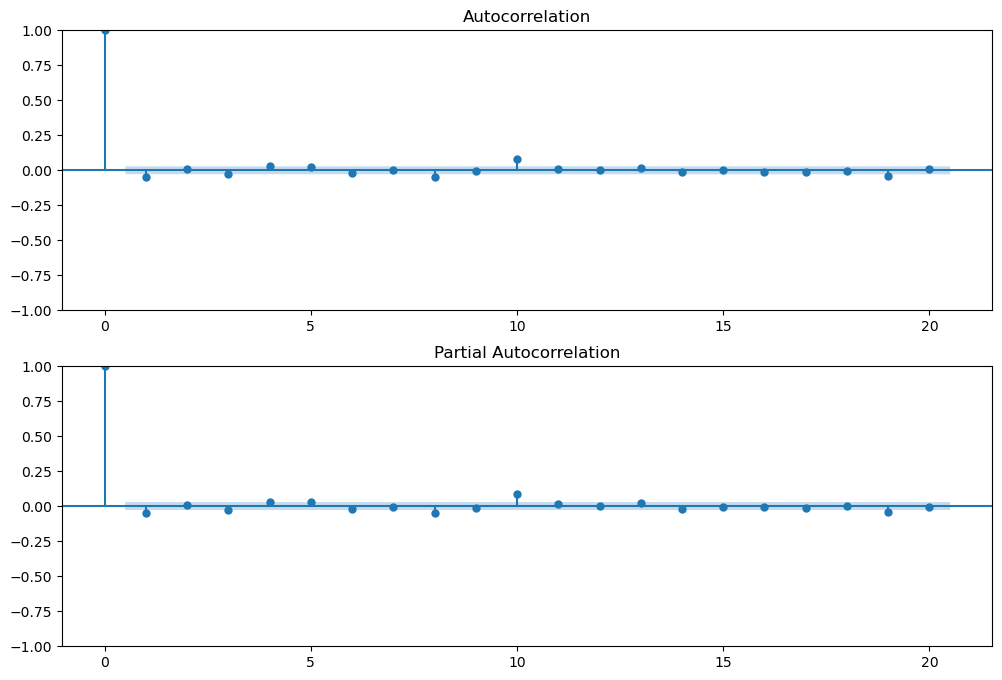

In [8]:
from statsmodels.tsa.stattools import adfuller

# DATA PREPARATION
# ======================

# Handle missing values
print(f"NaNs before handling: {pd.isna(daily_df['Close']).sum()}")
daily_df['Close'] = daily_df['Close'].ffill()  # Forward fill
print(f"NaNs after handling: {pd.isna(daily_df['Close']).sum()}")

# Check stationarity (Augmented Dickey-Fuller test)
result = adfuller(daily_df['Close'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')  # If p > 0.05, apply differencing

# Differencing to make data stationary (if needed)
daily_df['Close_diff'] = daily_df['Close'].diff().dropna()

# Plot ACF & PACF to determine ARIMA parameters
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(daily_df['Close_diff'].dropna(), lags=20, ax=ax1)
plot_pacf(daily_df['Close_diff'].dropna(), lags=20, ax=ax2)
plt.show()

The Auto-Correlation Function (ACF) and Partial Auto-Correlation Function (PACF) are plotted to determine ARIMA parameters (p, d, q). The ARIMA model is fitted, and forecasts are generated for the next 30 days.

### Model Training

In [10]:
# Split into train and test (last 30 days for testing)
test_size = 30
train = daily_df.iloc[:-test_size]
test = daily_df.iloc[-test_size:]
y_true = test['Close'].values

**1. ARIMA Model (AutoRegressive Integrated Moving Average)**

ARIMA is a statistical model for time series forecasting. It requires stationary data (mean and variance should not change over time). Augmented Dickey-Fuller (ADF) test is performed on daily closing prices to check for stationarity.

In [11]:
# ----- ARIMA -----
arima_model = ARIMA(train['Close'], order=(5,1,0))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=test_size)

**2. LSTM (Long Short-Term Memory)**

LSTMs are deep learning models that work well for sequential data like Bitcoin prices.

Preprocessing needed: 

- **Data Quality:** Ensure no NaNs remain after cleaning
- **Scaling:** Use MinMaxScaler to look for outliers
- **Model Architecture:** Added BatchNormalization and regularization
- **Training:** Lower learning rate with gradient clipping
- **Monitoring:** Added NaN detection callback

In [13]:
# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_df[['Close']])

# Prepare sequences
look_back = 60
def create_sequences(data, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create training sequences
train_size = len(scaled_data) - test_size
train_data = scaled_data[:train_size]
X_train, y_train = create_sequences(train_data, look_back)

# Create test sequences
test_sequence_start = train_size - look_back
test_sequence_data = scaled_data[test_sequence_start:train_size+test_size]
X_test, y_test = create_sequences(test_sequence_data, look_back)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(look_back, 1)),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1)
])

optimizer = Adam(learning_rate=0.0005, clipvalue=0.5)
lstm_model.compile(optimizer=optimizer, loss='mse')

# Train with early stopping
history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test[:, :test_size], y_test[:test_size]),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
    verbose=1
)

# Generate LSTM forecast
lstm_forecast = lstm_model.predict(X_test[:test_size])
lstm_forecast = scaler.inverse_transform(lstm_forecast)

C:\Users\milto\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - loss: 0.9355 - val_loss: 0.7927
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 0.6480 - val_loss: 0.5244
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.4841 - val_loss: 0.4544
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.3357 - val_loss: 0.0836
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.2278 - val_loss: 0.0715
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.1583 - val_loss: 0.0068
Epoch 7/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.1174 - val_loss: 0.0062
Epoch 8/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.0778 - val_loss: 0.0362
Epoch 9/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 0.0499 - val_loss: 0.0036
Epoch 10/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.0372 - val_loss: 0.0059
Epoch 11/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.0250 - val_loss: 0.0040
Epoch 12/100
148/148 ━━━━━━━━

### Key Observations

- Training loss ↓ while validation loss ↑ (0.0056 → 0.0167) suggests overfitting
- The model is memorizing training data rather than generalizing

**3. Prophet (Facebook's Forecasting Tool)**

Prophet is designed for business forecasting and works well with daily data. The dataset is reformatted for Prophet, with ds (datetime) and y (closing price).

Prophet model is trained with:

- Yearly and Weekly seasonality enabled
- Daily seasonality disabled
- Changepoint prior scale = 0.05 (controls trend flexibility)

Forecasts are generated for the next 30 days and plotted.

In [15]:
prophet_train = train.reset_index()[['datetime', 'Close']].rename(
    columns={'datetime': 'ds', 'Close': 'y'})
prophet_train['ds'] = prophet_train['ds'].dt.tz_localize(None)

prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05
)
prophet_model.fit(prophet_train)

future = prophet_model.make_future_dataframe(periods=test_size)
prophet_forecast = prophet_model.predict(future)
prophet_forecast = prophet_forecast.iloc[-test_size:]['yhat'].values

10:34:31 - cmdstanpy - INFO - Chain [1] start processing
10:34:33 - cmdstanpy - INFO - Chain [1] done processing


## Evaluation

In [17]:
# Calculate RMSE for all models
arima_rmse = np.sqrt(mean_squared_error(y_true, arima_forecast))
lstm_rmse = np.sqrt(mean_squared_error(y_true, lstm_forecast))
prophet_rmse = np.sqrt(mean_squared_error(y_true, prophet_forecast))

# Comparison table
results = pd.DataFrame({
    'Model': ['ARIMA', 'LSTM', 'Prophet'],
    'RMSE': [arima_rmse, lstm_rmse, prophet_rmse]
})

print("\nModel Comparison:")
print(results.sort_values('RMSE'))


Model Comparison:
     Model         RMSE
1     LSTM  8927.451745
0    ARIMA  9170.623207
2  Prophet  9264.847747


### Key Observations

- LSTM outperforms others but may not be significantly better given the small margin
- ARIMA shows surprisingly strong performance for a simpler model
- Prophet underperforms, possibly due to: Insufficient historical data for seasonality detection and cryptocurrency's unpredictable nature.

## Visualization

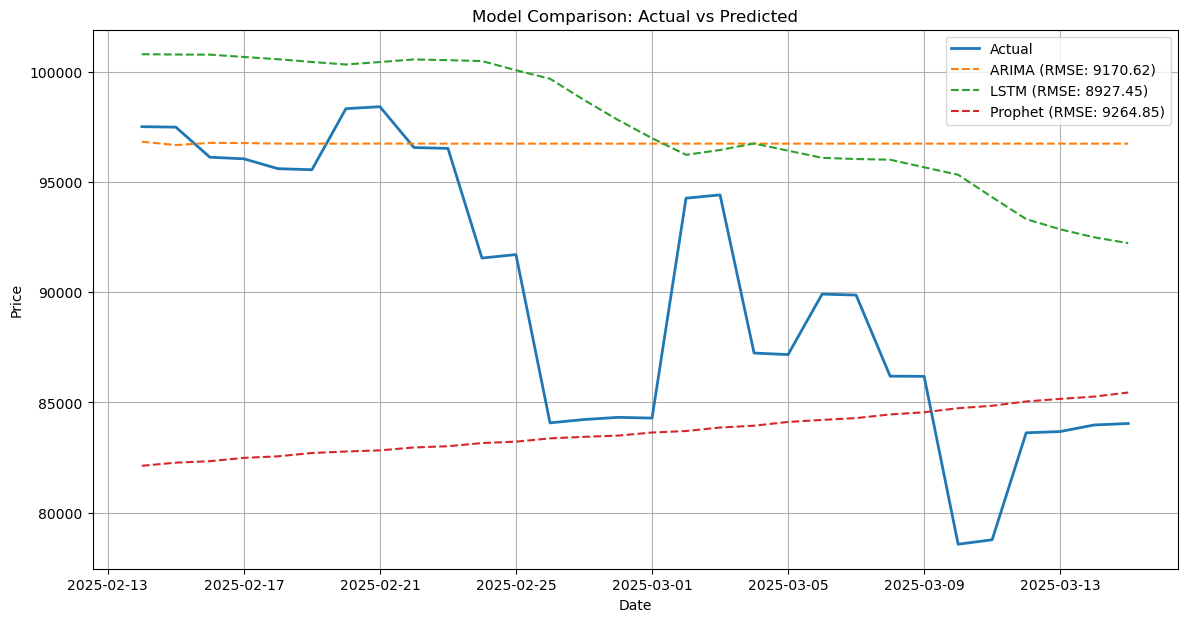

In [19]:
# Plot all forecasts together
plt.figure(figsize=(14, 7))
plt.plot(test.index, y_true, label='Actual', linewidth=2)
plt.plot(test.index, arima_forecast, label=f'ARIMA (RMSE: {arima_rmse:.2f})', linestyle='--')
plt.plot(test.index, lstm_forecast, label=f'LSTM (RMSE: {lstm_rmse:.2f})', linestyle='--')
plt.plot(test.index, prophet_forecast, label=f'Prophet (RMSE: {prophet_rmse:.2f})', linestyle='--')
plt.title('Model Comparison: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Conclusion

This project developed and compared three distinct approaches for Bitcoin price forecasting: **ARIMA (a traditional time-series model), LSTM (a deep learning method), and Facebook Prophet (a hybrid forecasting tool).** The models were evaluated on their ability to predict 30 days of Bitcoin prices, with key findings revealing:

### Performance Insights

- The **LSTM model achieved the lowest RMSE (8,927)**, demonstrating the potential of deep learning in capturing complex, non-linear patterns in cryptocurrency prices.
- **ARIMA (RMSE: 9,171)** performed competitively, highlighting that simpler statistical models can remain effective for financial time-series forecasting.
- **Prophet (RMSE: 9,265)**, while slightly less accurate, provided interpretable seasonality trends and confidence intervals, which are valuable for risk assessment.

### Challenges and Limitations

- **Volatility:** Bitcoin’s inherent price volatility made all models prone to higher error rates, especially during sudden market shifts.
- **Overfitting:** The LSTM’s rising validation loss (vs. training loss) suggested overfitting, necessitating stricter regularization or more data.
- **Data Dependencies:** All models relied solely on historical price data; incorporating external features (e.g., trading volume, sentiment analysis) might improve accuracy.

### Key Insights

- For short-term forecasts, the **LSTM or ARIMA models** are preferable due to their precision.
- For long-term trend analysis with uncertainty quantification, **Prophet** offers advantages in interpretability.
- Future work could explore **ensemble methods** (e.g., combining LSTM and ARIMA) or **hybrid models** integrating macroeconomic indicators.